## Studying the MCMC alpha=1 and spike-and-slab algorithms

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from implementations.mcmc_l1 import sample

In [2]:
RANDOM_SEED = 2022
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
import arviz as az
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

#### Loading the data

In [4]:
f = open("./data/spambase.columns", "r")
headers = [line.split(":")[0] for line in f]+["class"]

df = pd.read_csv("./data/spambase.data", header=None) 
df.columns = headers
df.insert(0, "intercept", 1)
df["class"] = df["class"].replace(0,-1)

df.sample(5)

,intercept,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
233,1,0.00,0.00,0.72,0.0,1.81,0.00,0.00,0.00,0.00,...,0.053,0.265,0.000,0.000,0.000,0.0,1.543,13,88,1
3010,1,0.05,0.00,0.05,0.0,0.00,0.00,0.00,0.00,0.53,...,0.115,0.173,0.041,0.000,0.016,0.0,2.853,47,896,-1
505,1,0.00,0.35,0.35,0.0,1.07,0.00,0.00,0.35,0.00,...,0.000,0.233,0.000,0.233,0.233,0.0,3.414,25,140,1
4136,1,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.000,1.066,0.000,0.213,0.000,0.0,1.333,3,36,-1
313,1,0.18,0.00,0.18,0.0,1.57,0.36,0.06,0.06,0.06,...,0.010,0.052,0.000,0.010,0.167,0.0,1.740,12,442,1


In [5]:
# Compute X by multiplying each row by the class
X = np.array(df.drop('class', axis=1)) * np.array(df["class"]).reshape(-1,1)

In [6]:
# Number of samples and of dimensions
n, k = X.shape
n, k

(4601, 58)

In [7]:
# Compute variance matrix
sigma = df.drop('class', axis=1).std(axis=0)
sigma[0] = 1
sigma.shape

(58,)

### Study of MCMC alpha=1

#### Sampling

In [8]:
n_chains = 2 # number of chains
T = 2000 # number of iterations
n_start = 200 # burn in

We now draw samples with our `sample` function, that implements the authors' algorithm from section 4.1 of the paper.

In [9]:
nu = 1
betas1 = np.zeros((n_chains,T,k))
for i in range(n_chains):
    betas1[i] = sample(X, sigma, rng, nu, T)

nu = 1e-3
betas2 = np.zeros((n_chains,T,k))
for i in range(n_chains):
    betas2[i] = sample(X, sigma, rng, nu, T)

Step 500
Step 1000
Step 1500
End of sampling: 0 lambda coeffs removed
Step 500
Step 1000
Step 1500
End of sampling: 0 lambda coeffs removed
Step 500
Step 1000
Step 1500
End of sampling: 0 lambda coeffs removed
Step 500
Step 1000
Step 1500
End of sampling: 0 lambda coeffs removed


####  Sparsity of the coefficients

For each coefficient of $\beta$, we chose to average the results from all chains and for all time steps after a burn-in period of length `n_start`. We then plot the standardized value of $\beta$, as advised in the paper.

In [10]:
betas1_mean_chain = betas1.mean(axis=0)/n_chains
std_betas1 = betas1_mean_chain[n_start:].mean(axis=0)*sigma

betas2_mean_chain = betas2.mean(axis=0)/n_chains
std_betas2 = betas2_mean_chain[n_start:].mean(axis=0)*sigma

We can also compute an empirical quantile interval for $\beta$, at level 95%.

In [11]:
lower_bound1 = np.quantile(betas1_mean_chain, 0.025, axis = 0)
lower_bound2 = np.quantile(betas2_mean_chain, 0.025, axis = 0)

upper_bound1 = np.quantile(betas1_mean_chain, 1-0.025, axis = 0)
upper_bound2 = np.quantile(betas2_mean_chain, 1-0.025, axis = 0)

err1 = upper_bound1-lower_bound1
err2 = upper_bound2-lower_bound2

We summarize the results in the following plot:

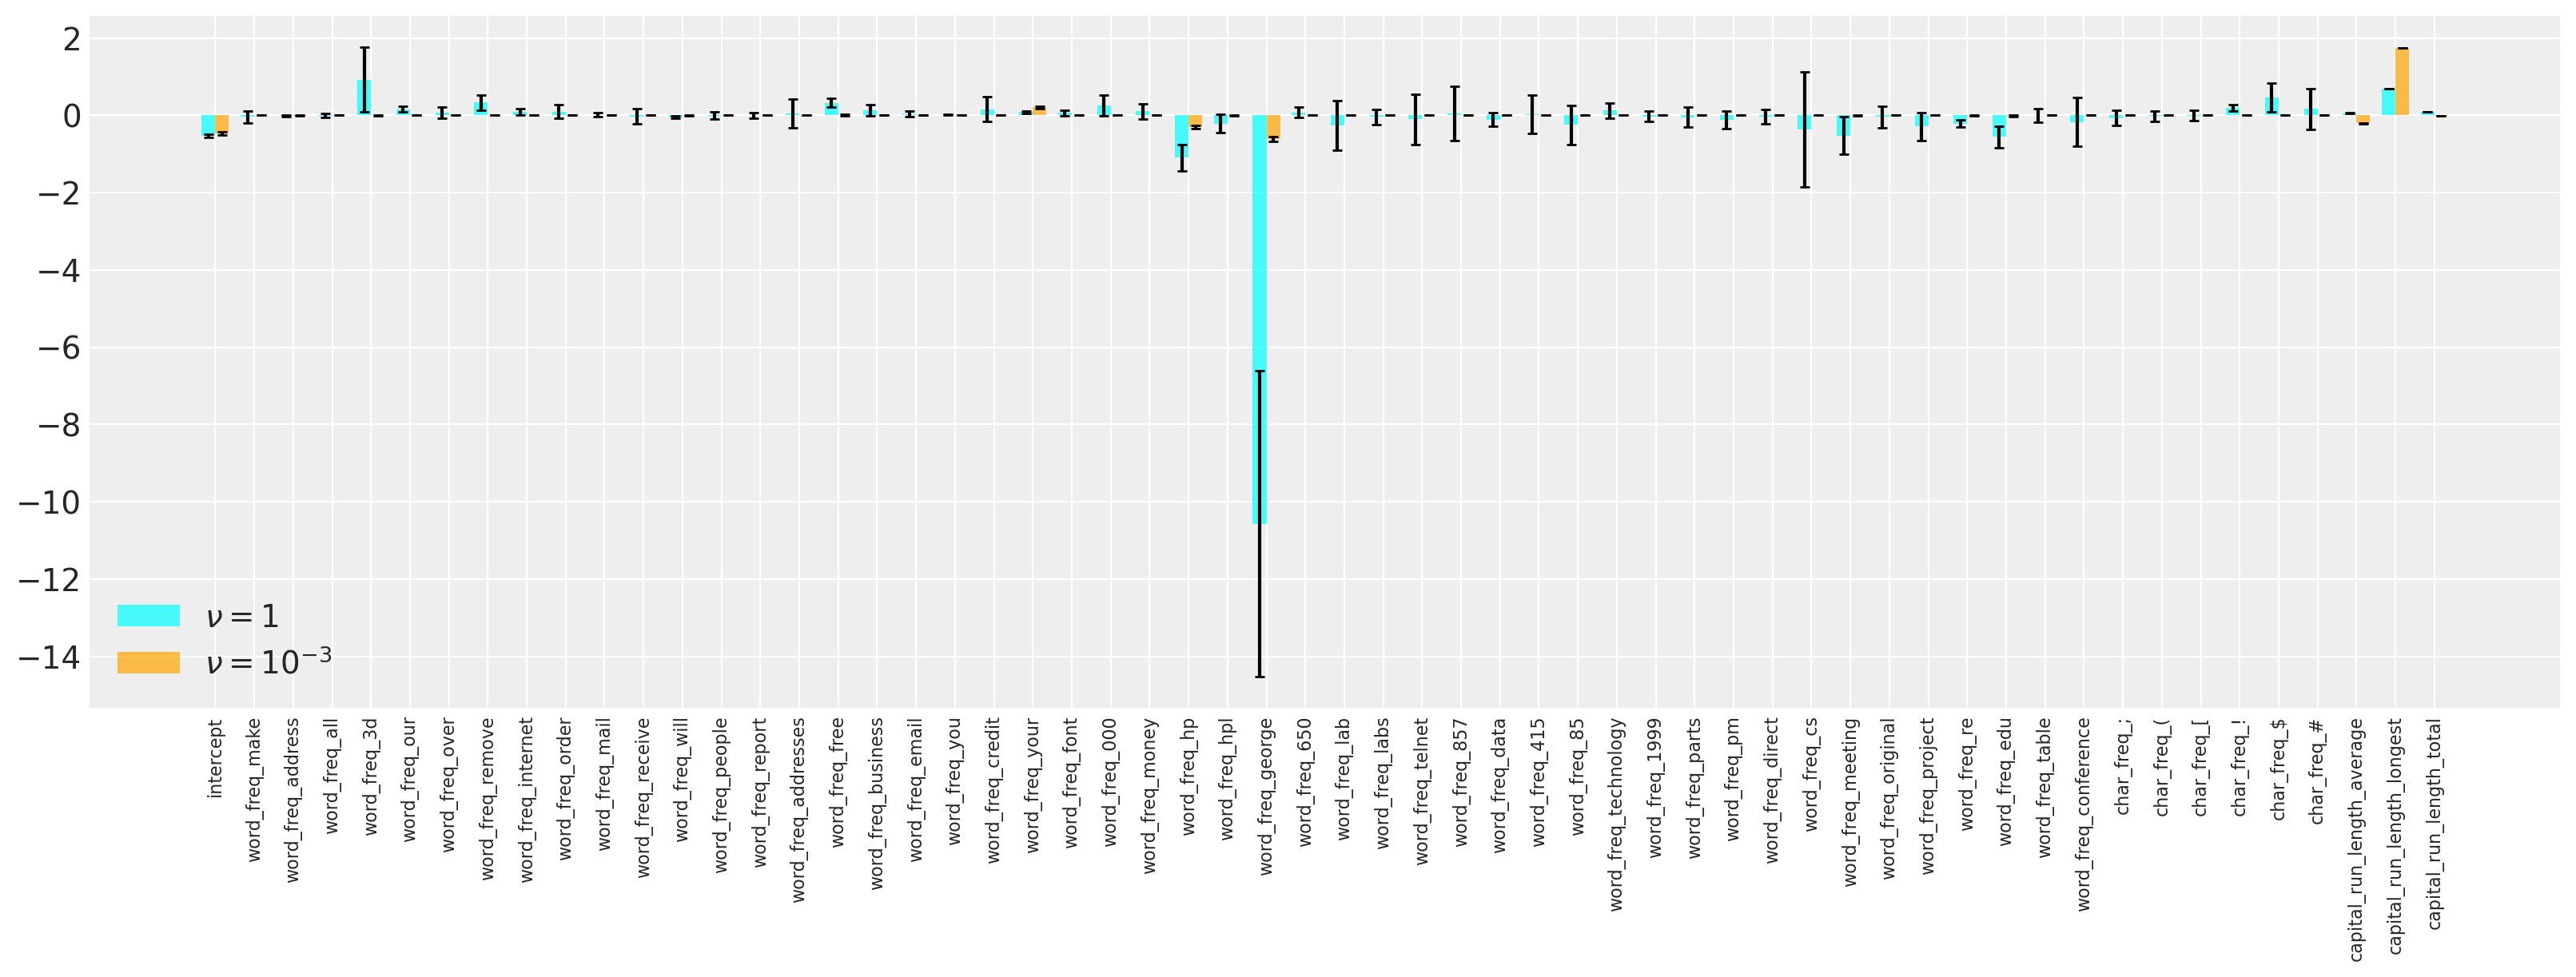

In [17]:
x = np.arange(k)
width = 0.35

fig, ax = plt.subplots(figsize=(16, 6))
bar1 = ax.bar(x - width / 2, std_betas1, width, label='$ν = 1$', alpha=.7, yerr=err1, capsize=2, color="cyan")
bar2 = ax.bar(x + width / 2, std_betas2, width, label='$ν = 10^{-3}$', alpha=.7, yerr=err2, capsize=2, color="orange")

ax.set_xticks(x)
ticks = df.columns[:-1]
ax.set_xticklabels(ticks, fontsize=8)

plt.xticks(rotation=90)
#plt.yscale("log")
plt.legend()
plt.show()

#### Convergence of the chains

In [13]:
n_coeffs = 2
coeffs = np.random.randint(k, size = n_coeffs)
colors = ["blue", "red", "green"]

For ν = 1


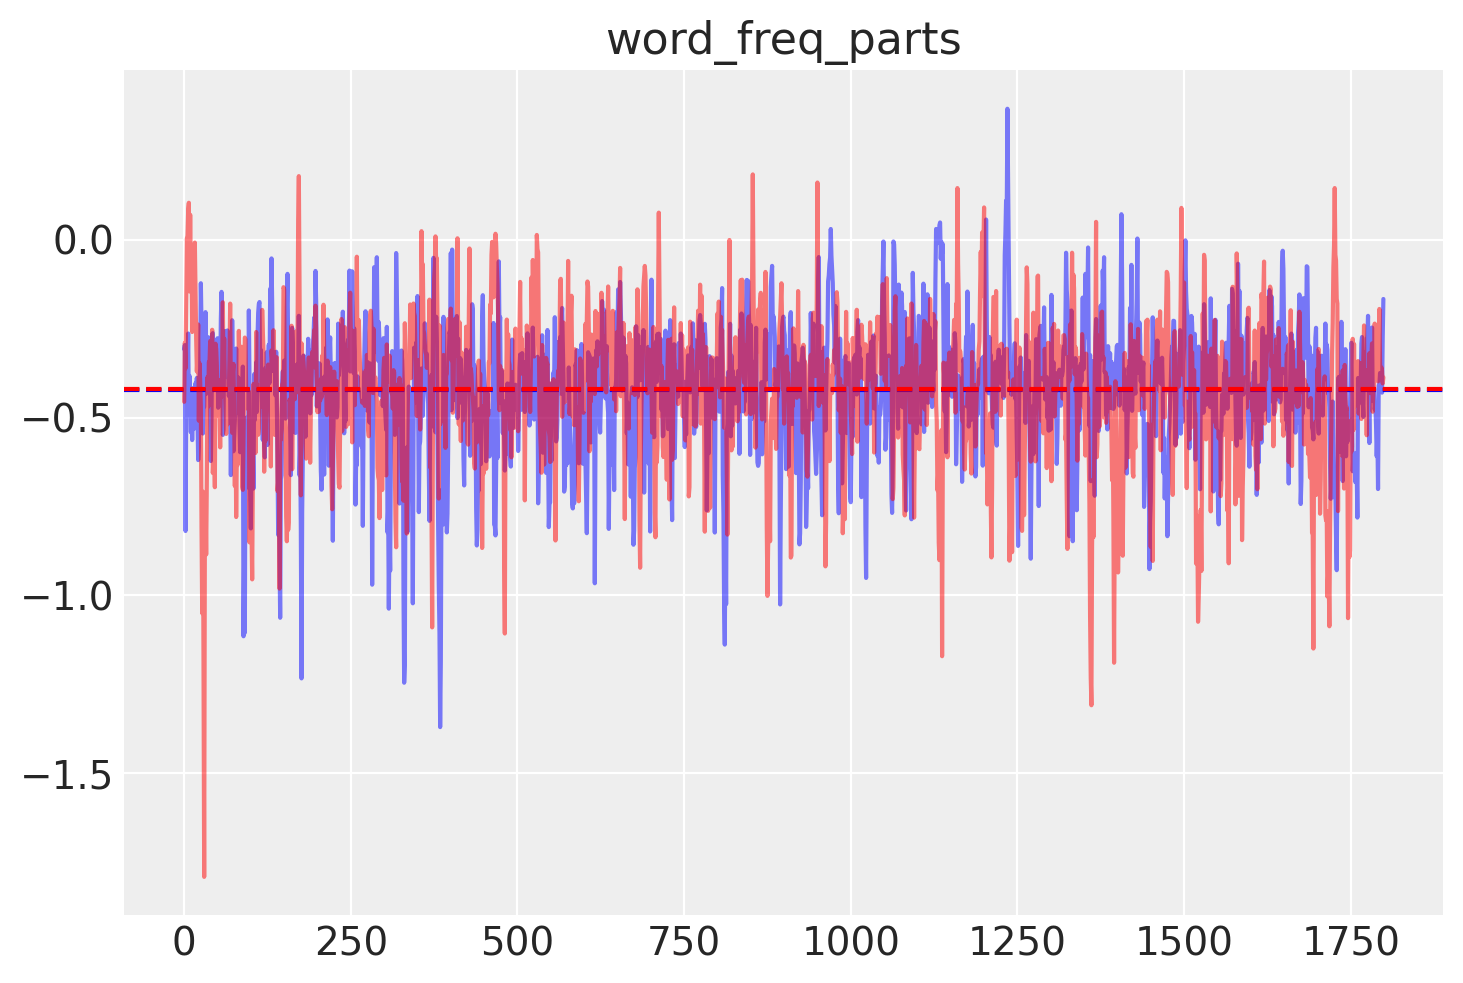

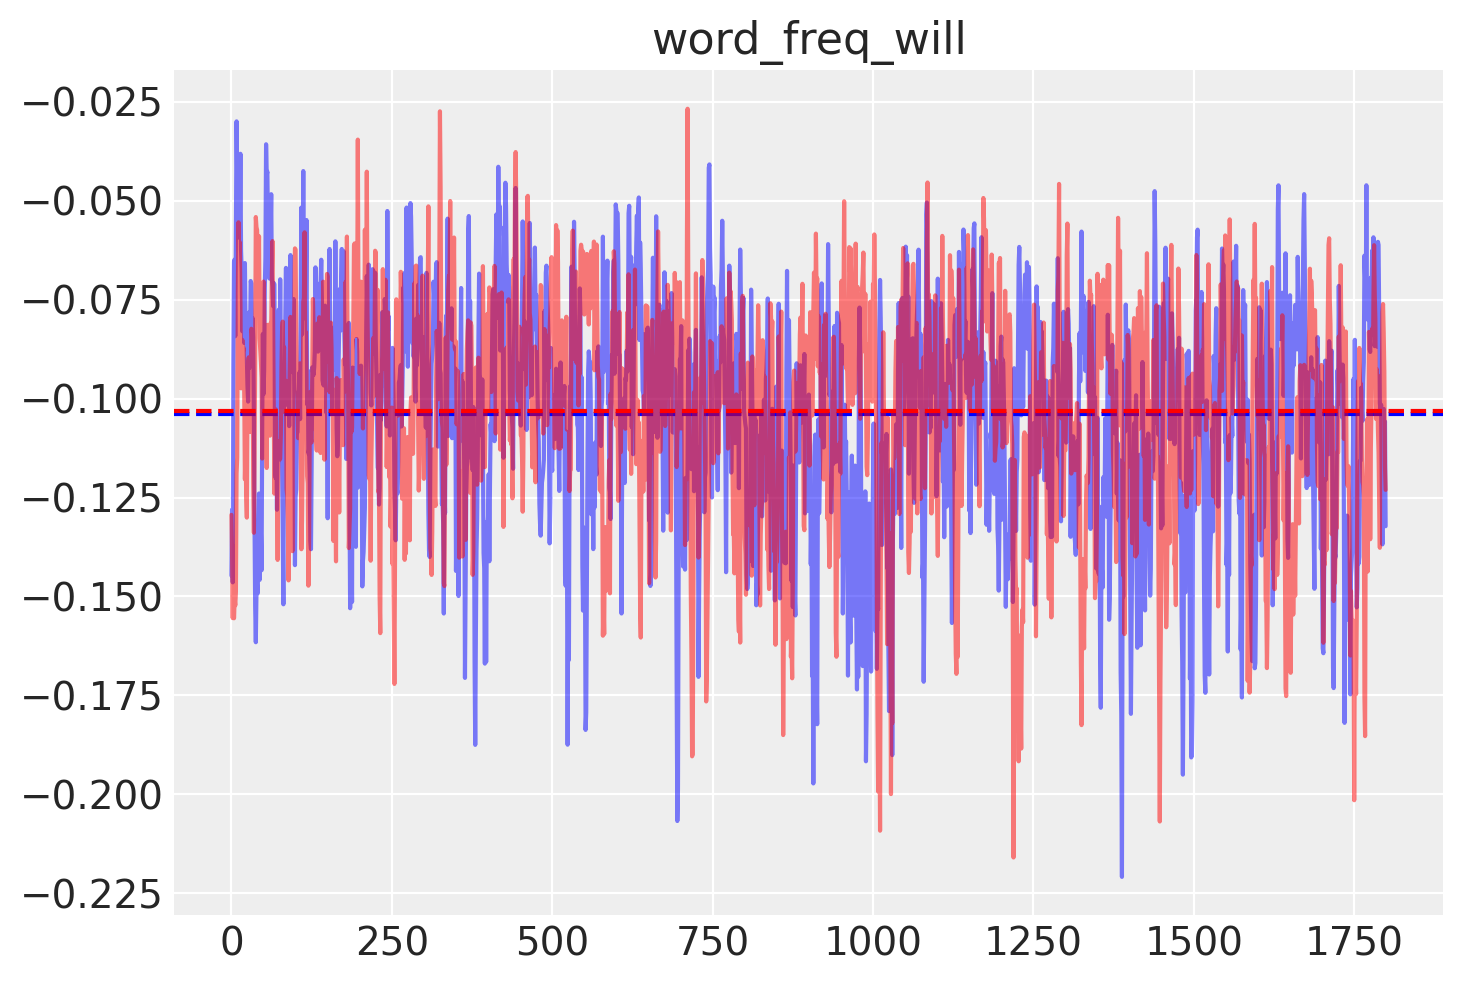

In [14]:
print('For ν = 1')
for coeff in coeffs:
    for i in range(n_chains):
        trajectory = betas1[i,n_start:,coeff]
        plt.plot(trajectory, color = colors[i], alpha = 0.5)
        plt.axhline(y=np.mean(trajectory), linestyle="--", color = colors[i])
    plt.title(ticks[coeff])
    plt.show()

For ν = 10^{-3}


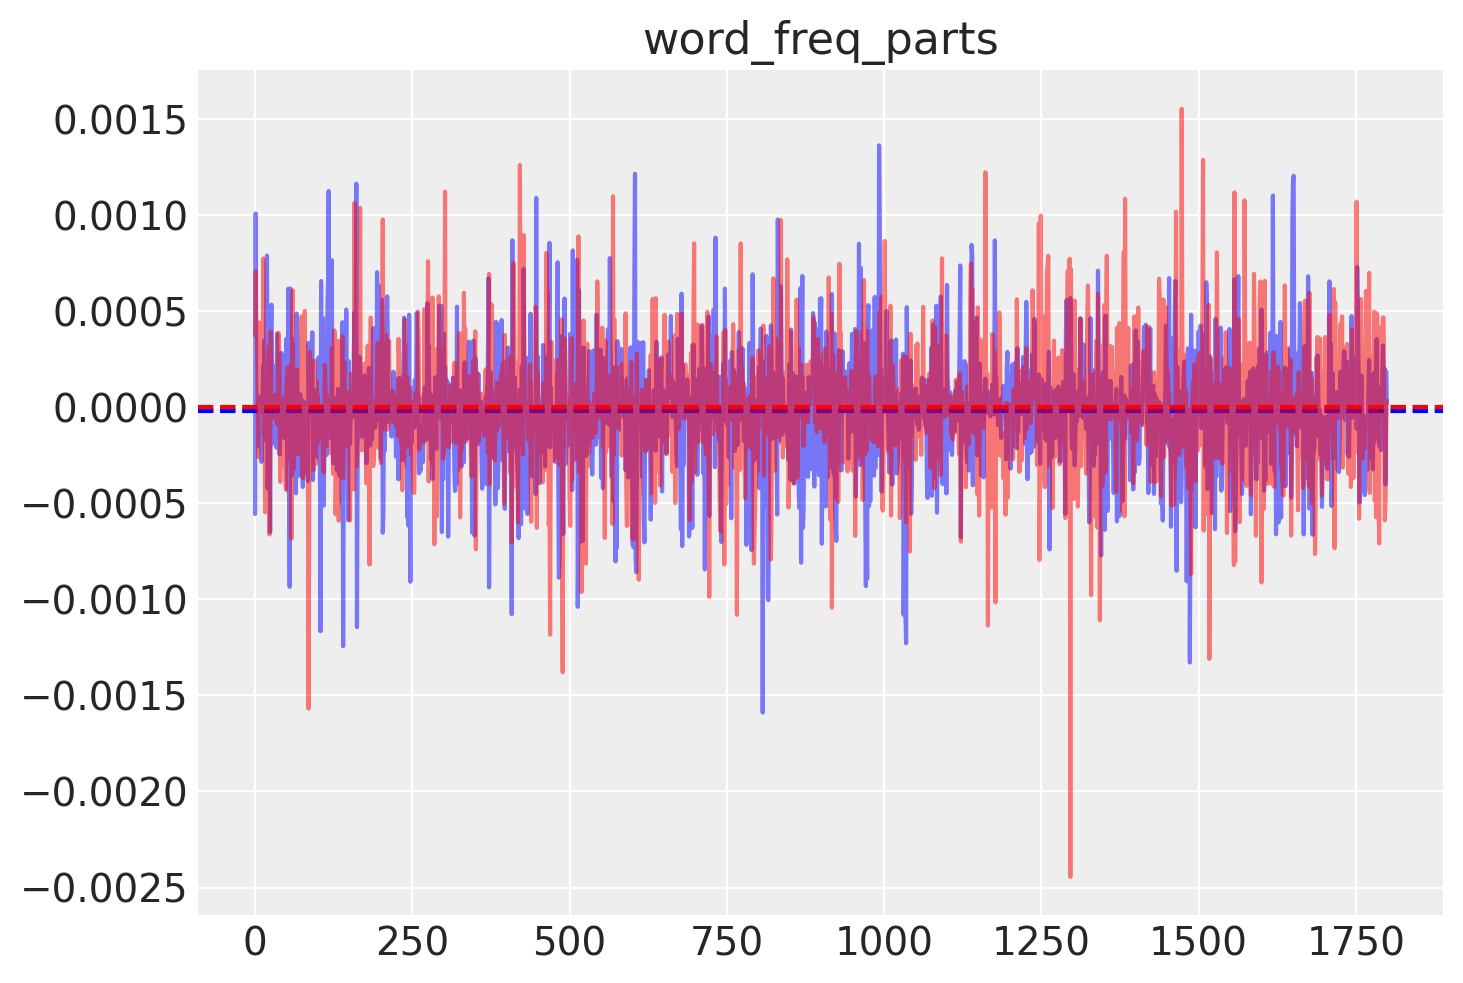

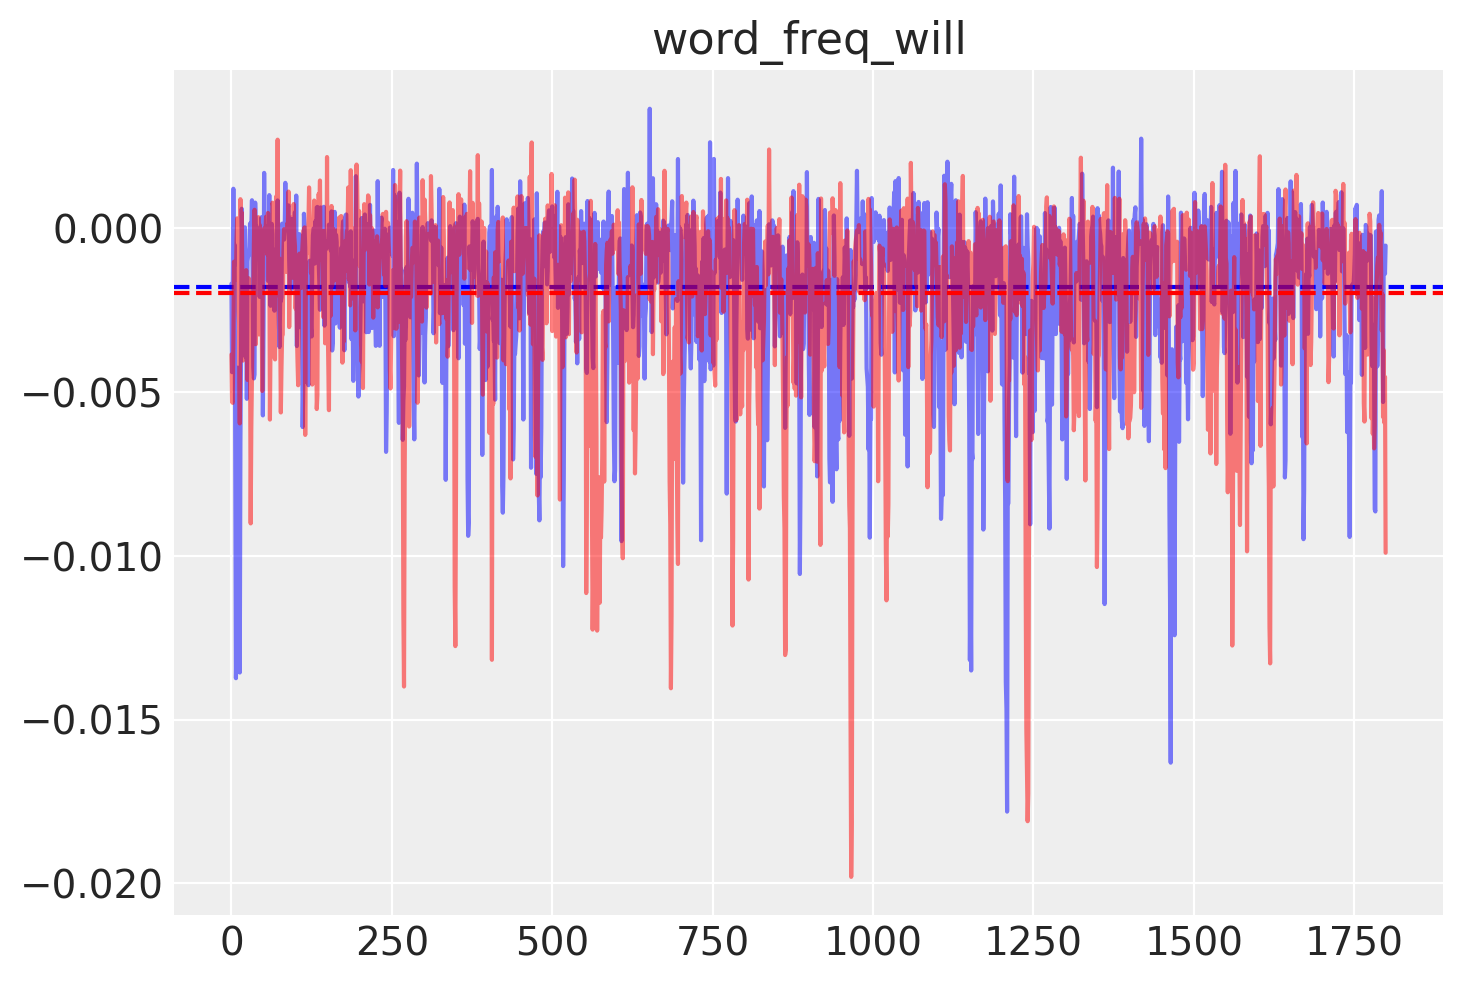

In [15]:
print('For ν = 10^{-3}')
for coeff in coeffs:
    for i in range(n_chains):
        trajectory = betas2[i,n_start:,coeff]
        plt.plot(trajectory, color = colors[i], alpha = 0.5)
        plt.axhline(y=np.mean(trajectory), linestyle="--", color = colors[i])
    plt.title(ticks[coeff])
    plt.show()

We can observe that the chains seem to mix pretty well according to the plots.  
Running 10 000 iterations as the authors do would probaby be safer, but unfortunately our computers can't handle that amount of computations.